# Before begins

This notebook is written in google colab.

To see some interactive plots, please enter the colab link Below.

<a href="https://colab.research.google.com/drive/1n9XYmcvefp6rSD-rH7uZqfw3eVQ_cnxh?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# Overview


## Competition Description

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/5407/logos/thumb76_76.png" width=50 align='left' alt="Open in Colab" /></a>
&nbsp; 
<font size="5">[House Prices - Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)</font>

<br>

- Problem type: Regression
  - Predicting the sale prices of residential homes in Ames, Iowa based on the aspects of the houses.
- evaluation metric: Root Mean Squared Log Error (RMSLE)

<br>

## Notebook Description

This notebook provides the '**proper workflow**' for kaggle submission.

The workflow is divided into three main steps.
1. Data preprocessing
2. Model selection (hyper parameter tuning, model combination, model comparison)
3. Training final model & Prediction on Test-set

At each stage, detailed descriptions of the work and an appropriate procedure will be provided.

Through this notebook, readers can learn the 'proper workflow' to be done for kaggle submission, 
and using this as a basic structure, someone will be able to apply this to other competitions easily with some adjustments

**Warnings**:
- The purpose of this notebook
  - This notebook focuses on the 'procedure' rather than the 'result'. 
  - Thus this notebook does not guide you on how to achieve the top score. Since I personally think that any result can only have a meaning through an appropriate procedure.
  - But since this is a competition, it cannot be avoided that the score is important. Following this notebook, you will get the top 15% (score: 0.12519) result in this competition

- The readers this notebook is intended for
  - Who are aware of the basic usage of data processing tools (e.g., numpy, pandas)
  - Who are aware of the basic concepts of machine learning models 


# 0. Configuration

Set the configurations for this notebook

In [ ]:
config = {'data_name' : 'House_Price', 
          'random_state' : 2022
}

# 1. Data preprocessing

The data preprocessing works are divided into 9 steps here.

Some of these steps are mandatory and some are optional.

Optional steps are marked separately.

It is important to go through each step in order.
Be careful not to reverse the order.

## 1.1. Load Dataset

Load train-set and test-set on working environment

Please download the data from [(Kaggle) House Price](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) and upload on your google drive in the path 'content/drive/MyDrive/Work/Kaggle/House_Price/Data'



### > Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/{}/Data/train.csv'.format(config['data_name']))
test = pd.read_csv('/content/drive/MyDrive/Work/Kaggle/{}/Data/test.csv'.format(config['data_name']))

### > Concatenate the 'train' and 'test' data for preprocessing

Data preprocessing work should be applied equally for train-set and test-set.

In order to work at once, exclude the output variable 'SalePrice' from 'train' and combine 'train' with 'test'.

In [ ]:
all_features = pd.concat((train.drop(['Id','SalePrice'], axis=1), test.drop(['Id'], axis=1)), axis=0)

y_train = train['SalePrice']

## 1-2. Missing Value Treatment

Missing (NA) values in Data must be treated properly before model training.

There are three main treatment methods:
1. Remove the variables which have NA values
2. Remove the rows (observations) which have NA values
3. Impute the NA values with other values

Which of the above methods is chosen depends on the analyst's discretion.
It is important to choose the appropriate method for the situation.

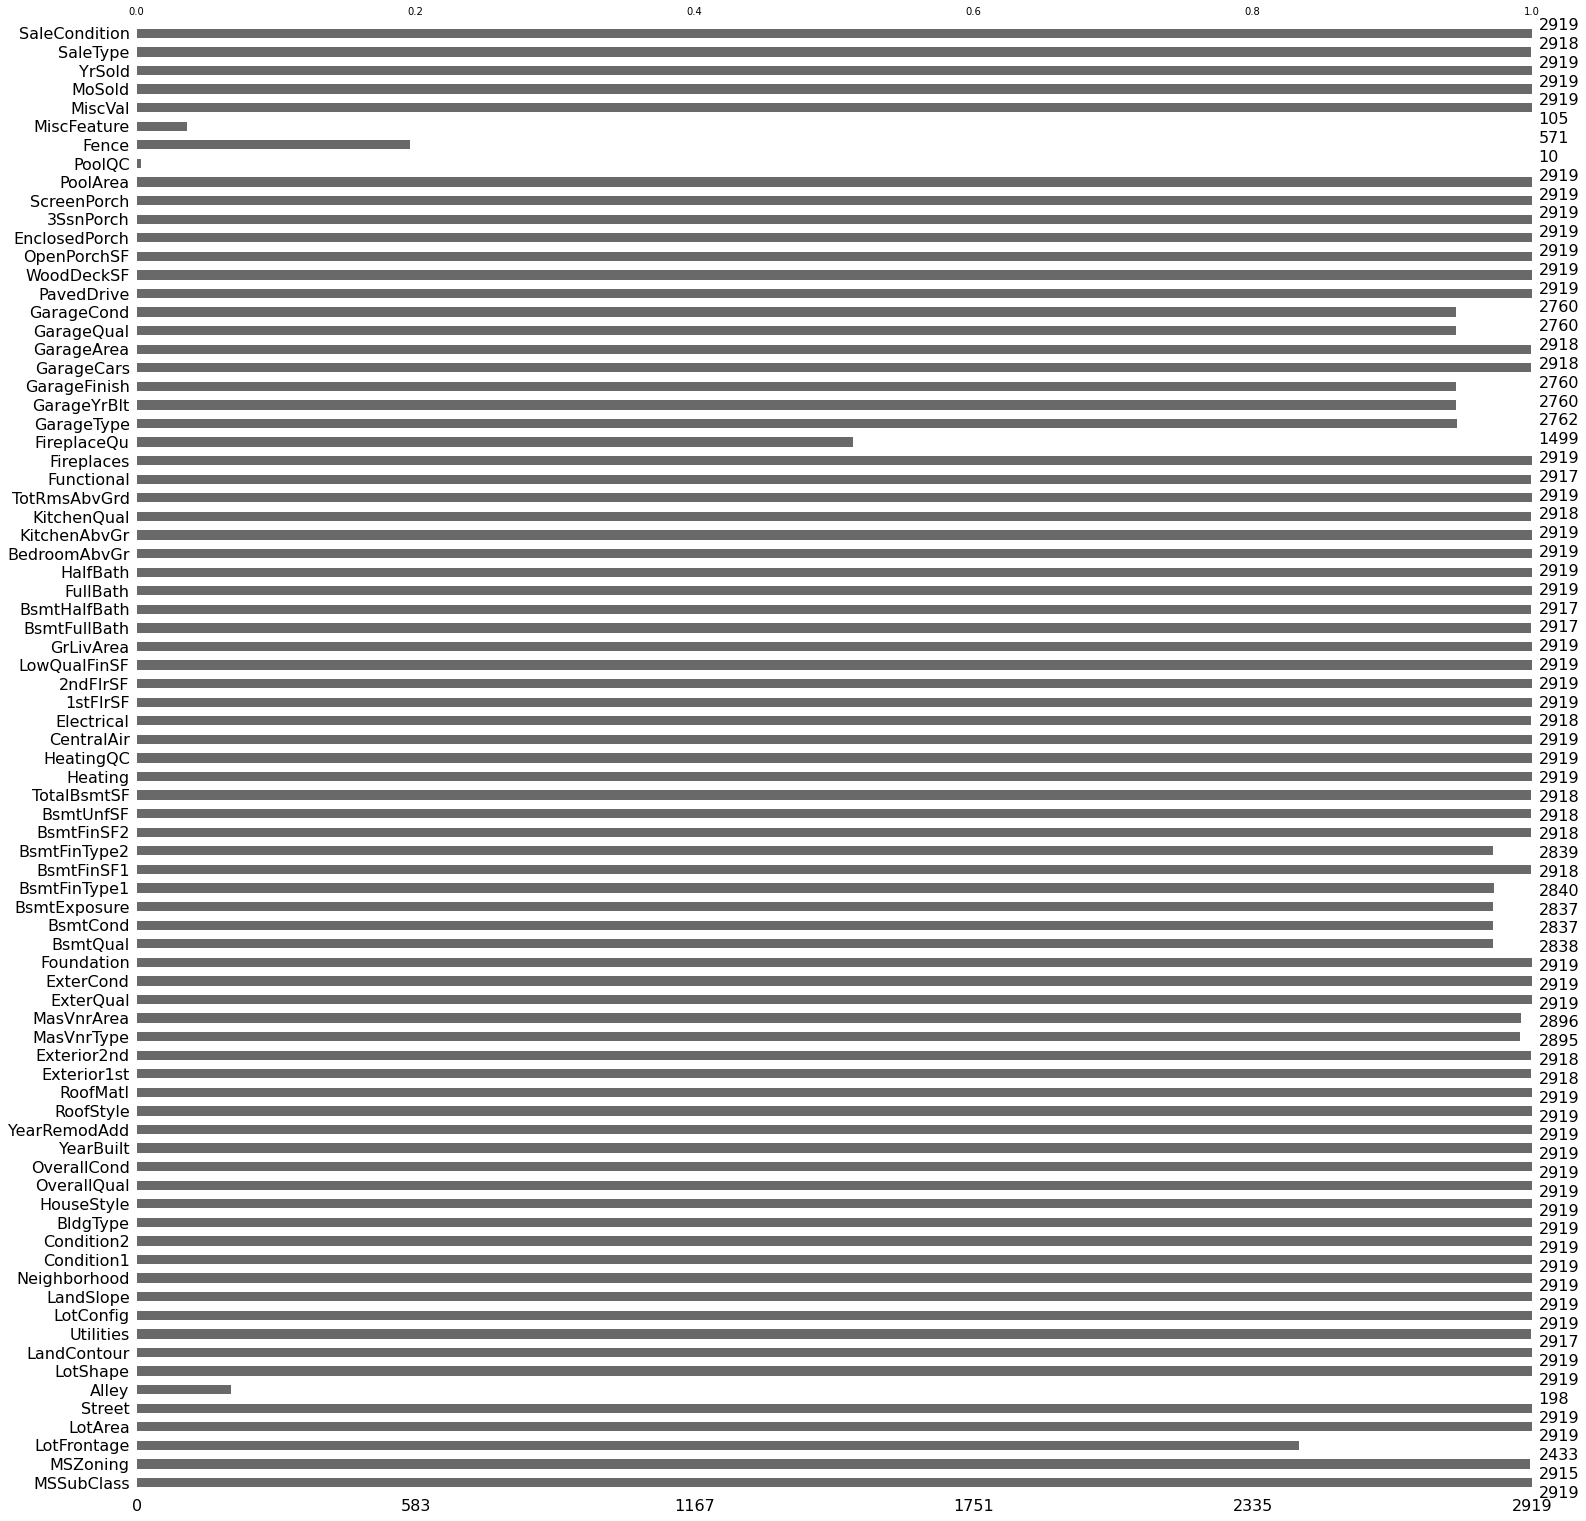

In [ ]:
import missingno as msno
msno.bar(all_features)

### > Categorical variables
- Method:
  - Replace 'NA' with 'None'
  - Replace 'NA' with 'Mode values'
  - Drop variables


#### >> Replace 'NA' with 'None'

According to the data description, 'NA' values ​​in some variables indicate that the value is not missing, but has the meaning of 'None'.

For example, 'NA' in 'GarageType' represents that the garage does not exist in the house.

In [ ]:
# NA <- None
NA_None_list = ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 
           'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']
df = all_features.loc[:,NA_None_list]

all_features.loc[:,NA_None_list] = df.fillna('None')   

#### >> Replace 'NA' with mode() value

In [ ]:
# NA <- Mode value
NA_Mode_list = ['MSZoning', 'Functional', 'Electrical', 'KitchenQual', 'SaleType', 
                'Exterior1st', 'Exterior2nd', 'Utilities']
df = all_features.loc[:, NA_Mode_list]

all_features.loc[:, NA_Mode_list] = df.fillna(df.mode().iloc[0])

#### >> Drop variables

Remove variables with a ratio of NA values ​​greater than 50%

In [ ]:
# NA <- Drop
NA_drop_list = all_features.columns[(all_features.isnull().sum()/all_features.shape[0])>0.5]
all_features.drop(NA_drop_list, axis=1, inplace=True)

### > Numeric variables
- Method:
  - Replace NA by 'median value' of the variable grouped by another (relevant) categorical variable
  - Replace NA by 'prediction value' of the linear model with relevant input variable 
  - Replace NA by values of the other (closely related) variable
  - Replace NA by '0' 
  

#### >> Replace NA by 'median value' of the variable grouped by another (relevant) categorical variable

The figures below show that the distribution of y-axis variable is different depending on the x-axis variable values.

(ANOVA test is used to determine whether the differences between groups are significant.)

In [ ]:
import plotly.express as px
fig = px.box(all_features, x='Neighborhood', y='LotFrontage', color='Neighborhood', width=800, height=400)
fig.show()

import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('LotFrontage ~ Neighborhood', data=all_features).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                     sum_sq      df          F         PR(>F)
Neighborhood  354702.462753    24.0  36.662697  1.468147e-143
Residual      970700.025533  2408.0        NaN            NaN


In [ ]:
fig = px.box(all_features, x='MasVnrType', y='MasVnrArea', color='MasVnrType', width=800, height=400)
fig.show()

import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('MasVnrArea ~ MasVnrType', data=all_features).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq      df           F  PR(>F)
MasVnrType  4.518340e+07     3.0  908.909447     0.0
Residual    4.792204e+07  2892.0         NaN     NaN


In [ ]:
fig = px.box(all_features, x='GarageType', y='GarageArea', color='GarageType', width=800, height=400)
fig.show()

import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('GarageArea ~ GarageType', data=all_features).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                  sum_sq      df          F         PR(>F)
GarageType  4.656781e+07     6.0  254.52425  3.250706e-262
Residual    8.876619e+07  2911.0        NaN            NaN


In [ ]:
# NA <- Median by group of another categorical variable
all_features['LotFrontage'] = all_features['LotFrontage'].fillna(all_features.groupby('Neighborhood')['LotFrontage'].transform('median'))
all_features['MasVnrArea'] = all_features['MasVnrArea'].fillna(all_features.groupby('MasVnrType')['MasVnrArea'].transform('median'))
all_features['GarageArea'] = all_features['GarageArea'].fillna(all_features.groupby('GarageType')['GarageArea'].transform('median'))

#### >> Replace NA by 'prediction value' of the predictive model with relevant input variable 

Below figure shows that 'GarageArea' and 'GarageCars' are linearly related. 

According to this observation, replace 'NA' values in 'GarageCars' by prediction values of the predictive model trained with input variable 'GarageArea' and output variable 'GarageCars'

In [ ]:
px.scatter(all_features, x='GarageArea', y='GarageCars', width=400, height=400)

Procedure: 
  - Train the model (GarageCars ~ GarageArea) without 'NA' observations in 'GarageCars'
  - Predict on NA observations in GarageCars with the model
  - Replace NA by predicted values

In [ ]:
# NA <- Prediction value by predictive model with relevant variable

from sklearn.linear_model import LogisticRegression
# Train
X = all_features.loc[~all_features['GarageCars'].isnull(), 'GarageArea'].values.reshape(-1,1)
y = all_features.loc[~all_features['GarageCars'].isnull(), 'GarageCars'].values
reg = LogisticRegression(penalty='none', max_iter=1000)
reg.fit(X, y)
# Prediction
pred = reg.predict(all_features.loc[all_features['GarageCars'].isnull(), 'GarageArea'].values.reshape(-1,1))
# Replace NA by prediction value
all_features.loc[all_features['GarageCars'].isnull(), 'GarageCars'] = pred.astype('int64')

#### >> Replace NA by values of the another (closely related) variable

When 'GarageYrBlt' is 'NaN', we can infer that garage does not exist in that house. 

Furthermore, below table shows that every house with 'GarageYrBlt' = NaN has 'GarageType' = None

In [ ]:
all_features.loc[all_features['GarageYrBlt'].isnull(),all_features.columns.str.startswith('Garage')].head()

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
39,None,NaN,None,0.0,0.0,None,None
48,None,NaN,None,0.0,0.0,None,None
78,None,NaN,None,0.0,0.0,None,None
88,None,NaN,None,0.0,0.0,None,None
89,None,NaN,None,0.0,0.0,None,None


But we can not replace NaN values in 'GarageYrBlt' to 0!

Since it represents the information of 'year'.
When 'GarageYrBlt'=0, it means that this garage was constructed in 'year 0' which is non-sense.

Thus I suggest the alternative way which focuses on the relationship between 'GarageYrBlt' and 'YearBuilt'.
Below plot shows there exists a linear relationship between them.

So we will replace the NA value in 'GarageYrBlt' to the value of 'YearBuilt' for each observation

In [ ]:
px.scatter(all_features, x='GarageYrBlt', y='YearBuilt', width=600, height=400)

By the way, we can observe that there is an outlier whose 'GarageYrBlt' value is '2207'. 

We modify this value to '2006' which is the value of 'YearBuilt' of the house.

In [ ]:
# Modify the wrong value (replace wrong value by 'YearBuilt' value of that observation)
all_features['GarageYrBlt'].replace(2207, 2006, inplace=True)

# NA in GarageYrBlt <- 'YearBuilt' values
all_features.loc[:, 'GarageYrBlt'] = all_features.loc[:,'GarageYrBlt'].fillna(all_features['YearBuilt'])

#### >> Replace NA by '0' 

Below table shows that when ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'] values are all 'NaN', other 'Bsmt' variables have 'None' or '0' values. 

In [ ]:
NA_list = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
all_features.loc[all_features.loc[:,NA_list].isnull().sum(axis=1).astype('bool'), all_features.columns.str.contains('Bsmt')].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
660,None,None,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN
728,None,None,None,None,0.0,None,0.0,0.0,0.0,NaN,NaN


Through this, we can infer that there is no basement at those houses.

Thus We replace NaN values to '0' since ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'] are integer or float variables

In [ ]:
NA_zero_list = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
                'BsmtFullBath', 'BsmtHalfBath']
df = all_features.loc[:, NA_zero_list]
all_features.loc[:, NA_zero_list] = df.fillna(0)

### > Check missing values again

Make sure there is no NA value in the processed data-set

In [ ]:
all_features.isnull().sum().values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

## 1-3. Adding new features (*optional*)

New variables can be created using the given data.
These variables are called 'derived variables'.

New informations can be added by creating appropriate derived variables.

This can have a positive effect on model performance. (Not always)

### > Insights from data

#### >> Had the house remodeled?
If 'YearBuilt' $\neq$ 'YearRemodAdd', Then we can infer that there was a remodeling after the first construction.


In [ ]:
all_features['Remod'] = 'None'
all_features.loc[all_features['YearBuilt']!=all_features['YearRemodAdd'],'Remod'] = 'Yes'

#### >> Was it a new house?
If 'YearBuilt' == 'YrSold', Then we can infer that that house was sold as soon as it was built

In [ ]:
all_features['IsNew'] = 'None'
all_features.loc[all_features['YearBuilt']==all_features['YrSold'],'IsNew'] = 'Yes'

## 1-4. Variable transformation

### > Data type transformation
Specify the data type that matches the characteristics of the variable.

#### >> int to object

- MSSubClass
  - Given the data_description, 'MSSubClass' indicates the type of dwelling involved in the sale 

- YrSold
  - 'YrSold' values vary from 2006 to 2010. Since the real estate market fluctuates year by year (e.g., 2008 financial cris) it would be better to take the 'YrSold' as a categorical variable not as an integer 

- MoSold
  - Real estate market also fluctuate month by month. Thus also take the 'MoSold' vairable as a categorical variable



In [ ]:
# int -> object
int_to_obj_list = ['MSSubClass', 'YrSold', 'MoSold']
all_features[int_to_obj_list] = all_features[int_to_obj_list].astype('object')

#### >> object to int

According to the data description, some variables indicate the quality of a facility. 

Since the assesed quality has a superiority and inferiority relationship between values, it is more appropriate to convert it to an integer type.

In [ ]:
# object -> int
obj_to_int_list = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
                    'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 
                    'BsmtFinType1', 'BsmtFinType2', 'Functional', 'BsmtExposure', 
                    'GarageFinish', 'LandSlope', 'PavedDrive']

all_features[obj_to_int_list] = all_features[obj_to_int_list].replace(
    {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5,
     'Unf':1, 'RFn':2, 'Fin':3,
     'No':1, 'Mn':2, 'Av':3,
     'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6,
     'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7,
     'Gtl':0, 'Mod':1, 'Sev':2,
     'N':0, 'P':1, 'Y':2
    }
)

## 1-5. Dummify categorical variables

In the case of linear modeling without regularization, the first or last column should be dropped (to prevent linear dependency), but here, for the convenience of using the factorization model, one-hot encoding method is used that does not drop any columns.

In [ ]:
data_set = pd.get_dummies(all_features, drop_first=False)

## 1-6. Scaling continuous variables

Integer of float type variables are measured in different units (e.g., YearBuilt: by year, BsmfSF1: by square feet).

MinMaxScaling maps all variables from 0 to 1 in order to consider only relative information, not absolute magnitudes of the values.

Besides, it is known that scaling is often more stable in parameter optimization when training a model.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_set = scaler.fit_transform(data_set)

## 1-7. Split Train & Test set

In [ ]:
n_train = train.shape[0]
X_train = data_set[:n_train].astype('float32')
X_test = data_set[n_train:].astype('float32')
y_train = train['SalePrice'].values.astype('float32')

## 1-8. Outlier Detection (*optional*)

Detect and remove outlier observations that exist in the train-set.

- Methodology: [Isolation Forest](https://ieeexplore.ieee.org/abstract/document/4781136/?casa_token=V7U3M1UIykoAAAAA:kww9pojtMeJtXaBcNmw0eVlJaXEGGICi1ogmeHUFMpgJ2h_XCbSd2yBU5mRgd7zEJrXZ01z2)
  - How it works
    - Isolation Forest applies a decision tree that repeats splits based on the 'random criterion' for the given data unitl only one observation remains in every terminal node (this is defined as 'isolation').
    - Based on the number of splits used for isolation, 'normality' is defined. A smaller value means a higher degree of outlierness.
    - By applying this decision tree several times, the average of the measured 'normality' values ​​is derived as the final 'normality' value.
  - Assumptions
    - Outliers require relatively few splits to be isolated.
    - For normal data, the number of splits required to be isolated is relatively large.
  - Outlier determination
    - Determines whether it is an outlier or not based on the measured 'normality' value.
      - sklearn's IsolationForest package determines based on '0' 
      - I, personally, think it is better to set the discriminant criterion by considering the 'distribution' of the 'normality' values.
      - The details of the method is given below.

In [ ]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    n_jobs=-1,
    random_state=config['random_state'])

clf.fit(X_train)
normality_df = pd.DataFrame(clf.decision_function(X_train), columns=['normality'])

The discriminant value (threshold) is defined by calculating the 1st quartile ($q_1$) and 3rd quartile ($q_3$) on the distribution of the measured normality values.

$threshold = q_1 - k*(q_3 - q_1)$

- In this case, set $k=1.5$.

This discriminant method is adapted from Tukey's boxplot idea.
In the distribution of any continuous variable, Tukey designates observations smaller than that value or larger than q_3 + k*(q_3 - q_1) as outliers.

Our methodology does not apply the above method to a specific variable, but applies the method to the obtained normality.

That is, it is based on the assumption that an outlier will be far left from the other observations in the measured normality distribution.

In [ ]:
def outlier_threshold(normality, k=1.5):
  q1 = np.quantile(normality, 0.25)
  q3 = np.quantile(normality, 0.75)  
  threshold = q1 - k*(q3-q1)
  return threshold

threshold = outlier_threshold(normality_df['normality'].values, k=1.5)

fig = px.histogram(normality_df, x='normality', width=400, height=400)
fig.add_vline(x=threshold, line_width=3, line_dash="dash", line_color="red")
fig.show()

In [ ]:
import plotly.express as px
px.box(normality_df, x='normality', orientation='h', width=400, height=400)

In [ ]:
X_train = X_train[normality_df['normality'].values>=threshold]
y_train = y_train[normality_df['normality'].values>=threshold]

print('{} observations are removed from train_set'.format(train.shape[0] - X_train.shape[0]))

27 observations are removed from train_set


## 1-9. Output variable transformation (*optional*)

Please refer to the below article which shows the benefit of trasnforming the output variable with log function before learning a linear regression model

[Effect of transforming the targets in regression model](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

In [ ]:
import plotly.express as px
px.histogram(y_train, width=400, height=400)

In [ ]:
import plotly.express as px
px.histogram(np.log1p(y_train), width=400, height=400)

In [ ]:
y_train_trans = np.log1p(y_train)

# 2. Model Selection

Our goal is to build a model that predicts the expected value of the sale price (y) of a house by using informations about the house (x). The formula can be expressed as:

$E[y|X=x] \\ <=> y = f(x) + \epsilon$

This is a typical regression problem, and various machine learning models can be used. This notebook uses the following models.
- (Regularized) Linear regression
- Support vector machine
- Random forest
- Xgboost
- Multi-layer perceptron
- Factorization machine

However, we have to "choose" one final methodology to make predictions on the test-set.
To do so, a “fair evaluation” of the models is essential. "Fair evaluation" must satisfy the following two conditions.

1. Select best hyperparameters for each model
  - Bad hyperparmeter values could lead to the bad model performance.
2. Same evaluation method
  - If the evaluation method is not the same, comparison between models itself is impossible.

When comparing models through an evaluation method that satisfies the above two conditions,
Only then the final model can be selected.




### > Install Packages

In [ ]:
! pip install tune_sklearn ray[tune] skorch

     |████████████████████████████████| 40 kB 4.6 MB/s 
     |████████████████████████████████| 59.6 MB 1.3 MB/s 
     |████████████████████████████████| 155 kB 54.9 MB/s 
     |████████████████████████████████| 175 kB 54.7 MB/s 
     |████████████████████████████████| 125 kB 57.5 MB/s 


### > Make a dataframe for containing CV results and best hyper parameters

In [ ]:
model_list = []
for name in ['linear', 'svm', 'rf', 'xgb', 'mlp', 'fm']:
  model_list.append(np.full(5, name))
  
best_cv_df = pd.DataFrame({'model': np.hstack((model_list)), 'log_RMSE':None})

## 2-1. Hyper parameter tuning by using Tune_SKlearn (Ray Tune)

- Package: tune_sklearn
  - This package makes it easy to apply [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) to sklearn models.
  - Ray Tune is a python package that provides various hyperparameter tuning algorithms (HyperOpt, BayesianOptimization, ...).
- Tuning procedure
  - Define an appropriate search space for each model's hyperparameters.
  - 5-fold CV (Cross Validation) is performed for each specific hyper-parameter value combination of the search space by using the hyper-parameter tuning algorithm (HyperOpt)
    - Training: Training by using Scikit-Learn and Skorch packages
    - Validation: Evaluate the model using an appropriate evaluation metric
  - The hyperparameter with the highest average score of the CV result is designated as the optimal hyperparameter of the model.
    - Save this CV result and use for model comparison



### Linear regression

In [ ]:
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import SGDRegressor

# Define a search space
parameters = {
    'alpha': list(np.geomspace(1e-14, 1e-8, 8)),
    'loss': ['squared_error'],
    'penalty': ['l2'],
    'max_iter': [1000],
    'tol': list(np.geomspace(1e-7, 1e-1, 4)),
    'random_state': [config['random_state']],
}

# Specify the hyper parameter tuning algorithm
tune_search = TuneSearchCV(
    SGDRegressor(),
    parameters,
    search_optimization='hyperopt',
    n_trials=10,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error'],
    cv=5,
    refit='neg_root_mean_squared_error', # target metric of competition
    verbose=1
    )

# Run hyper parameter tuning
X = X_train 
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'linear'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_RMSE'] = cv_values[:5]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_neg_root_mean_squared_error')
fig.show()

### Support vector machine

In [ ]:
from tune_sklearn import TuneSearchCV
from sklearn.linear_model import SGDRegressor

# Define a search space
parameters = {
    'alpha': list(np.geomspace(1e-7, 1e-3, 3)),
    'epsilon': list(np.geomspace(1e-5, 1e-1, 3)),
    'loss': ['huber', 'epsilon_insensitive'],
    'tol': list(np.geomspace(1e-7, 1e-1, 4)),
    'max_iter': [1000],
    'penalty': ['l2'],
    'random_state': [config['random_state']]
}

# Specify the hyper parameter tuning algorithm
tune_search = TuneSearchCV(
    SGDRegressor(),
    parameters,
    search_optimization='hyperopt',
    n_trials=16,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error'],
    cv=5,
    refit='neg_root_mean_squared_error', # target metric of competition
    verbose=1
    )

# Run hyper parameter tuning
X = X_train 
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'svm'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_RMSE'] = cv_values[:5]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_neg_root_mean_squared_error')
fig.show()

(_Trainable pid=1264) /usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
(_Trainable pid=1264)   ConvergenceWarning,


### Random forest

In [ ]:
from tune_sklearn import TuneSearchCV
from sklearn.ensemble import RandomForestRegressor

parameters = {
    'n_estimators': [500, 1000, 2000],
    'criterion': ['squared_error'],
    'max_depth': [25, 30, 35],
    'max_features': ['auto'],
    'random_state': [config['random_state']]
}

# Specify the hyper parameter tuning algorithm
tune_search = TuneSearchCV(
    RandomForestRegressor(),
    parameters,
    search_optimization='hyperopt',
    n_trials=9,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error'],
    cv=5,
    refit='neg_root_mean_squared_error', # target metric of competition
    verbose=1
    )

# Run hyper parameter tuning
X = X_train 
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'rf'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_RMSE'] = cv_values[:5]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_neg_root_mean_squared_error')
fig.show()

### XGBoost

In [ ]:
from tune_sklearn import TuneSearchCV
from xgboost import XGBRegressor

parameters = {
    'n_estimators': [500, 1000],
    'learning_rate': list(np.geomspace(1e-2, 1, 3)),
    'min_child_weight': [5, 10, 15],
    'gamma': list(np.geomspace(1e-2, 1, 3)),
    'subsample': [0.6, 1.0],
    'colsample_bytree': [0.6, 1.0],
    'max_depth': [5, 10, 15],
    'objective': ['reg:squarederror'],
    'random_state': [config['random_state']]
}

# Specify the hyper parameter tuning algorithm
tune_search = TuneSearchCV(
    XGBRegressor(),
    parameters,
    search_optimization='hyperopt',
    n_trials=9,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error'],
    cv=5,
    refit='neg_root_mean_squared_error', # target metric of competition
    verbose=1
    )

# Run hyper parameter tuning
X = X_train 
y = y_train_trans
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'xgb'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_RMSE'] = cv_values[:5]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_neg_root_mean_squared_error')
fig.show()

### Multi-layer perceptron

In [ ]:
import torch
from torch import nn
from skorch.regressor import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from tune_sklearn import TuneSearchCV


class MLP(nn.Module):
    def __init__(self, num_inputs=X_train.shape[1], num_outputs=1, layer1=512, layer2=256, dropout1=0, dropout2=0):
        super(MLP, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(num_inputs, layer1),
            nn.LeakyReLU(),
            nn.Dropout(dropout1),
            nn.Linear(layer1, layer2),
            nn.LeakyReLU(),
            nn.Dropout(dropout2),
            nn.Linear(layer2, num_outputs)
            )
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x  

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

mlp = NeuralNetRegressor(
    MLP(num_inputs=X_train.shape[1], num_outputs=1),
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=try_gpu(),
    verbose=0,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=7,
                             threshold=1e-5, lower_is_better=True)]
                          )

parameters = {
    'lr': list(np.geomspace(1e-5, 1e-2, 4)),
    'module__layer1': [128, 256, 512],
    'module__layer2': [128, 256, 512],
    'module__dropout1': [0, 0.1],
    'module__dropout2': [0, 0.1],
    'optimizer__weight_decay': list(np.geomspace(1e-5, 1e-1, 5)),
    'max_epochs': [1000],
    'batch_size': [16, 32, 64]
    }

def use_gpu(device):
    return True if not device == 'cpu' else False 

tune_search = TuneSearchCV(
    mlp, 
    parameters, 
    search_optimization='hyperopt',
    n_trials=15,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error'],
    cv=5,
    refit='neg_root_mean_squared_error',
    mode='max',   
    use_gpu = use_gpu(try_gpu()),
    random_state=config['random_state'],
    verbose=1,
    )

# Run hyper parameter tuning
X = X_train 
y = y_train_trans.reshape(-1,1)
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'mlp'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_RMSE'] = cv_values[:5]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_neg_root_mean_squared_error')
fig.show()

### Factorization Machine

[Factorization Machines](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=5694074&casa_token=WNncod4Fzy0AAAAA:06BUH6Q3Mh-HhboU-WV9p4h5AykMCWcYedWlcFDLtNw4tIkNWZg9oadIz32UuMx9rFDyqOTGY1w&tag=1), proposed by Steffen Rendle in 2010, is a supervised algorithm that can be used for classification, regression, and ranking tasks. 
It quickly took notice and became a popular and impactful method for making predictions and recommendations.



In [ ]:
def prepro_for_fm(X_train, X_test, bin_method='sturges'):
  n_train = X_train.shape[0]
  all = np.vstack((X_train, X_test))

  col_num_uniq = np.apply_along_axis(lambda x: len(np.unique(x)), 0,  all)
  remain_iidx = (col_num_uniq<=2)
  to_bin_iidx = (col_num_uniq>2)

  all_remain = all[:,remain_iidx]
  all_to_bin = all[:,to_bin_iidx]
  
  for iter in range(all_to_bin.shape[1]):
    bin_size = len(np.histogram(all_to_bin[:,iter], bins=bin_method)[0])
    all_to_bin[:,iter] = pd.cut(all_to_bin[:,iter], bins=bin_size, labels=False)

  all_to_bin_df = pd.DataFrame(all_to_bin).astype('object')
  all_to_bin_array = pd.get_dummies(all_to_bin_df, drop_first=False).to_numpy()

  all_array = np.hstack((all_to_bin_array, all_remain)).astype(np.int64)
  field_dims = all_array.shape[1]
  all_fm = np.vstack((np.apply_along_axis(lambda x: np.where(x==1), 1, all_array)))

  return all_fm[:n_train], all_fm[n_train:], field_dims


X_train_fm, X_test_fm, field_dims = prepro_for_fm(X_train, X_test, bin_method='sturges')

In [ ]:
import torch
from torch import nn
from skorch.regressor import NeuralNetRegressor
from skorch.callbacks import EarlyStopping
from tune_sklearn import TuneSearchCV

class FM(nn.Module):
    def __init__(self, num_inputs=field_dims, num_factors=2, output_dim=1):
        super(FM, self).__init__()
        self.embedding = nn.Embedding(num_inputs, num_factors)
        self.fc = nn.Embedding(num_inputs, 1)
        self.bias = nn.Parameter(torch.zeros((output_dim,)))

    def forward(self, x):
        square_of_sum = torch.sum(self.embedding(x), dim=1)**2
        sum_of_square = torch.sum(self.embedding(x)**2, dim=1)
        x = self.bias + self.fc(x).sum(1) + 0.5 * (square_of_sum - sum_of_square).sum(dim=1, keepdim=True)
        return x 

def try_gpu(i=0): 
    return f'cuda:{i}' if torch.cuda.device_count() >= i + 1 else 'cpu'

fm = NeuralNetRegressor(
    FM(num_inputs=field_dims, num_factors=20, output_dim=1),
    optimizer=torch.optim.Adam,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=try_gpu(),
    verbose=0,
    callbacks=[EarlyStopping(monitor='valid_loss', patience=7,
                             threshold=1e-5, lower_is_better=True)]
                          )

params = {
    'lr': list(np.geomspace(1e-4, 1e-1, 4)),
    'module__num_factors': [2, 10, 20],
    'optimizer__weight_decay': list(np.geomspace(1e-5, 1e-1, 5)),
    'max_epochs': [3000],
    'batch_size': [32, 128]
    }

def use_gpu(device):
    return True if not device == 'cpu' else False 

tune_search = TuneSearchCV(
    fm, 
    params, 
    search_optimization='hyperopt',
    n_trials=10,
    n_jobs=-1,
    scoring=['neg_root_mean_squared_error'],
    cv=5,
    refit='neg_root_mean_squared_error',
    mode='max',   
    use_gpu = use_gpu(try_gpu()),
    random_state=config['random_state'],
    verbose=1,
    )


# Run hyper parameter tuning
X = X_train_fm
y = y_train_trans.reshape(-1,1)
tune_search.fit(X, y)

# Save the tuning results 
model_name = 'fm'

## Save the optimal hyper parmater values
best_cv_df.loc[best_cv_df['model']==model_name, 'best_hyper_param'] = str(tune_search.best_params_)

## Save the CV results
cv_df = pd.DataFrame(tune_search.cv_results_)
cv_values = cv_df.loc[tune_search.best_index_, cv_df.columns.str.startswith('split')].values
best_cv_df.loc[best_cv_df['model']==model_name, 'log_RMSE'] = cv_values[:5]

# Visualize the tuning results with parallel coordinate plot
tune_result_df = pd.concat([pd.DataFrame(tune_search.cv_results_['params']), cv_df.loc[:,cv_df.columns.str.startswith('mean')] ], axis=1)
import plotly.express as px
fig = px.parallel_coordinates(tune_result_df, color='mean_test_neg_root_mean_squared_error')
fig.show()

In [ ]:
import os 
save_path = '/content/drive/MyDrive/Work/Kaggle/{}/Result'.format(config['data_name'])
if not os.path.exists(save_path):
  os.makedirs(save_path)
file_path = os.path.join(save_path, 'best_cv_results.csv')
best_cv_df.to_csv(file_path, index=False)

## 2-2. Model comparison based on CV results with best hyper parameters

Compare the CV results (measured using the best hyper parameter values)

The figure below shows that 'fm' model inferiors to the other models.



In [ ]:
fig = px.box(best_cv_df, x='model', y='log_RMSE', color='model', width=600)
fig.show()

Thus remove 'fm' in the 'best_cv_df' and compare the other models 

The figure below shows that \\
xgb >> rf >= svm > linear > mlp

In [ ]:
best_cv_df = best_cv_df[best_cv_df['model']!='fm']

fig = px.box(best_cv_df, x='model', y='log_RMSE', color='model', width=600)
fig.show()

## 2-3. Model Combination

Although it is possible to select a final model among the models above, it has been observed that in many cases the combination of predicted values ​​from multiple models leads to improved prediction performance. ([Can multi-model combination really enhance the prediction skill of probabilistic ensemble forecasts?](https://rmets.onlinelibrary.wiley.com/doi/abs/10.1002/qj.210?casa_token=OwyF2RbEywAAAAAA:gahpwGRdOWzLXyafYQQt_voHOF8MedTBLd1SBv4vkdT3ZTLVoKZQj3zl-KbrhSkX5x8CndeCxwBoL_-S))

For regression problems, the final predicted values are derived by combining the predicted values in a 'proper way'.

This notebook uses the following two model combination methods.

1. Simple Average
2. Stacked Generalization (Stacking)


Model comparison needs to be done with single models (e.g., rf, xgb,...).
So model performance are measured by applying the same CV method as above.

### > Simple Average

The simple average method derives the final prediction value by 'averaging' the predicted values of multiple models.

The top 3 models (svm, rf, xgb) of the above CV results are selected as base estimators used for the combination of predicted values.

For example,
- Base Estimations
  - $f_{svm}(x)$ = 0.85
  - $f_{rf}(x)$ = 0.75
  - $f_{xgb}(x)$ = 0.80
- Final Estimation
  - $f_{average}(x)$  = 0.8 (= 0.85 + 0.75 + 0.80 + / 3)


In [ ]:
from sklearn.model_selection import KFold
from tqdm import notebook
from sklearn.metrics import mean_squared_error

def CV_ensemble(ensemble_name, ensemble_func, estimators, X_train, y_train, n_folds=5, shuffle=True, random_state=2022):
  kf = KFold(n_splits=5, random_state=random_state, shuffle=True)

  res_list = []
  for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Eval_CV'):
    X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]

    ensemble_pred= ensemble_func(estimators, X_train_train, y_train_train, X_valid)
    log_rmse = np.negative(mean_squared_error(y_valid, ensemble_pred, squared=False))

    res_list.append([ensemble_name, log_rmse])
  res_df = pd.DataFrame(np.vstack((res_list)))
  res_df.columns = ['model', 'log_RMSE']
  return res_df

def ensemble_average(estimators, X_train, y_train, X_test):
  preds = []
  for idx in range(len(estimators)):
    try:
      estimators[idx].module__num_factors
    except: # for other models
      estimators[idx].fit(X_train, y_train)
      preds.append([estimators[idx].predict(X_test)])
    else: # for factorization machine
      X_train_fm, X_test_fm, _ = prepro_for_fm(X_train, X_test)
      estimators[idx].fit(X_train_fm, y_train.reshape(-1,1)).astype(np.float32)
      preds.append([estimators[idx].predict(X_test_fm).reshape(-1)])
    
  pred_df = pd.DataFrame(np.vstack((preds)).transpose())
  return pred_df.mean(axis=1).values  

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

linear = SGDRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
svm = SGDRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='svm', 'best_hyper_param'].values[0]))
rf = RandomForestRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb = XGBRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp = mlp.set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))

estimators = [svm, rf, xgb]
estimators_name = 'svm_rf_xgb'
ensemble_name = 'average' + '_by_' + estimators_name

X = X_train
y = y_train_trans

res_df = CV_ensemble(ensemble_name, ensemble_average, estimators, X, y, n_folds=5, shuffle=True, random_state=config['random_state'])
best_cv_df = best_cv_df.append(res_df).reset_index(drop=True)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
fig = px.box(best_cv_df, x='model', y='log_RMSE', color='model', width=600)
fig.show()

### > Stacked generalization (Stacking)

In the [Stacked generalization](https://www.jair.org/index.php/jair/article/view/10228), the predicted values of base estimators are treated as the 'input data', and y (SalePrice) of each row is treated as the 'output variable'. 
The 'Meta Learner' is learned with these data and the predicted values of this model are derived as the final prediction values

- The 'Meta Learner' can be any of the regression models. However, this notebook uses a linear regression model for simplicity.

- As input data for 'Meta Learner', predicted values for validation data in CV of base estimators are obtained.

- Trained meta-learner predicts the final predicted values for the test-set by using the predicted values of the baes estimators for the test-set as input data.

The procedure is as follows:
1. (Base estimators) Run CV on Train-set
2. (Meta Learner) Train on CV predictions (predicted values on validation data of CV) with corresponding y values
3. (Base estimators) Train on Train-set
4. (Base estimators) Predict on Test-set
5. (Meta Learner) Predict on predicted values from step 4.

<img align='top' src='https://drive.google.com/uc?export=view&id=1uDxSIIFt8rUJkuIwRYU4lALvOPqlXPG5' width='600' height='400'>


For example,
- Base Estimations
  - $f_{svm}(x)$ = 0.85
  - $f_{rf}(x)$ = 0.75
  - $f_{xgb}(x)$ = 0.80
- Meta Learner (linear regression)
  - Parameter
    - intercept = 0.1
    - coefficient = [0.3, 0.1, 0.6]
  - $f_{stack}(x) = 0.795 = -0.1 + 0.4*0.85 + 0.1*0.75 + 0.6*0.80$

In [ ]:
from sklearn.model_selection import KFold
from tqdm import notebook
from sklearn.metrics import mean_squared_error


def stack_reg(estimators, X_train, y_train, X_test, n_folds=5, shuffle=True, random_state=2022):
  final_estimator = estimators[-1]
  kf = KFold(n_splits=n_folds, random_state=random_state, shuffle=shuffle)
  preds = []
  y_valid_list = []
  
  for train_idx, valid_idx in notebook.tqdm(kf.split(X_train), total=kf.get_n_splits(), desc='Stack_CV'):
    X_train_train, X_valid = X_train[train_idx], X_train[valid_idx]
    y_train_train, y_valid = y_train[train_idx], y_train[valid_idx]
    
    valid_preds = []
    for idx in range(len(estimators)-1):
      try:
        estimators[idx].module__num_factors
      except: # for other models
        estimators[idx].fit(X_train_train, y_train_train)
        valid_preds.append([estimators[idx].predict(X_valid)])
      else: # for factorization machine
        X_train_train_fm, X_valid_fm, _ = prepro_for_fm(X_train_train, X_valid)
        estimators[idx].fit(X_train_train_fm, y_train_train.reshape(-1,1)).astype(np.float32)
        valid_preds.append([estimators[idx].predict(X_valid_fm).reshape(-1)])
    
    preds.append(np.vstack((valid_preds)).transpose())
    y_valid_list.append(y_valid)

  stack_X_valid = np.vstack((preds))
  y_valid_list = np.hstack((y_valid_list))
  
  final_estimator.fit(stack_X_valid, y_valid_list)
  print('Training log_RMSE: {}'.format(mean_squared_error(final_estimator.predict(stack_X_valid), y_valid_list, squared=False)))
  print('Estimated coefficients: {} \n intercept: {}'.format(final_estimator.coef_, final_estimator.intercept_))

  
  test_preds =[]
  for idx in range(len(estimators)-1):
    try:
      estimators[idx].module__num_factors
    except: # for other models
      estimators[idx].fit(X_train, y_train)
      test_preds.append([estimators[idx].predict(X_test)])
    else: # for factorization machine
      X_train_fm, X_test_fm, _ = prepro_for_fm(X_train, X_test)
      estimators[idx].fit(X_train_fm, y_train.reshape(-1,1)).astype(np.float32)
      test_preds.append([estimators[idx].predict(X_test_fm).reshape(-1)])

  stack_X_test = np.vstack((test_preds)).transpose()
  return final_estimator.predict(stack_X_test)

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

linear = SGDRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
svm = SGDRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='svm', 'best_hyper_param'].values[0]))
rf = RandomForestRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb = XGBRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp = mlp.set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))

estimators = [svm, rf, xgb]
estimators_name = 'svm_rf_xgb'

# Final estimator
reg = LinearRegression()

estimators.append(reg)
ensemble_func = stack_reg
ensemble_name = 'stack_linear' + '_by_' + estimators_name

# Run CV 
X = X_train
y = y_train_trans

res_df = CV_ensemble(ensemble_name, ensemble_func, estimators, X, y, n_folds=5, shuffle=True, random_state=config['random_state'])
best_cv_df = best_cv_df.append(res_df)

Eval_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training log_RMSE: 0.10810210467502773
Estimated coefficients: [0.27401265 0.05808763 0.68821811] 
 intercept: -0.24180181972667114


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training log_RMSE: 0.11427582759435978
Estimated coefficients: [ 0.23754223 -0.01259877  0.78288326] 
 intercept: -0.08966468623819424


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training log_RMSE: 0.1156317207554122
Estimated coefficients: [0.29664346 0.08230907 0.63684453] 
 intercept: -0.18502107724683903


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training log_RMSE: 0.11503571766841739
Estimated coefficients: [0.31205747 0.0252778  0.67308552] 
 intercept: -0.1242206783917581


Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training log_RMSE: 0.11203656772425526
Estimated coefficients: [0.23375702 0.09334191 0.68823474] 
 intercept: -0.180868657111807


In [ ]:
import os 
save_path = '/content/drive/MyDrive/Work/Kaggle/{}/Result'.format(config['data_name'])
if not os.path.exists(save_path):
  os.makedirs(save_path)
file_path = os.path.join(save_path, 'best_cv_results.csv')
best_cv_df.to_csv(file_path, index=False)

## 2-4. Model Comparison based on CV results including model combination methods

Based on the figure below, we can observe that the  'stack_ridge_by_rf_xgb_mlp_fm' method as our best model

In [ ]:
fig = px.box(best_cv_df, x='model', y='log_RMSE', color='model', width=600)
fig.show()

# 3. Make a prediction with the best model

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

linear = SGDRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='linear', 'best_hyper_param'].values[0]))
svm = SGDRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='svm', 'best_hyper_param'].values[0]))
rf = RandomForestRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='rf', 'best_hyper_param'].values[0]))
xgb = XGBRegressor(**eval(best_cv_df.loc[best_cv_df['model']=='xgb', 'best_hyper_param'].values[0]))
mlp = mlp.set_params(**eval(best_cv_df.loc[best_cv_df['model']=='mlp', 'best_hyper_param'].values[0]))

estimators = [svm, rf, xgb]
estimators_name = 'svm_rf_xgb'

# Final estimator
reg = LinearRegression()

estimators.append(reg)
ensemble_func = stack_reg
ensemble_name = 'stack_linear' + '_by_' + estimators_name

# Run CV 
pred = stack_reg(estimators, X_train, y_train_trans, X_test, n_folds=5, shuffle=True, random_state=config['random_state'])
pred_trans = np.expm1(pred)
res_df = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred_trans})
res_df.to_csv('{}.csv'.format(ensemble_name), index=False)

Stack_CV:   0%|          | 0/5 [00:00<?, ?it/s]

Training log_RMSE: 0.11061168615904916
Estimated coefficients: [0.31402843 0.01302107 0.68199393] 
 intercept: -0.11058324160234356
